# <span style="color:green">**Clasificación de Datos MOCAP**</span>

**Estudiante:** <span style="color:blue">Mario García Moncayo </span>
**Director:** <span style="color:blue">Cristhian Kaori Valencia </span>
        
**Fecha:**   <span style="color:blue">22 de abril del 2024</span> 

CLASIFICACIÓN DE DATOS MOCAP SOBRE UNA DISCIPLINA DEPORTIVA USANDO MODELOS DE MACHINE LEARNING


In [1]:
#!pip install pymo
#!pip install pybvh


## <span style="color:blue">**Importar librerías** </span>

Traemos la carpeta **PYMO** previamente descargada en el ordenador local del URL: https://github.com/omimo/PyMO
y copiamos los archivos en la ruta de anaconda-jupyter, para hacer uso de los contenidos y parámetros de la misma, aparte cargamos los demás paquetes que vamos a usar

In [2]:
!pip install joblib

Defaulting to user installation because normal site-packages is not writeable


In [3]:
#Load packages
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
import pickle
import timeit
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from pymo.parsers import BVHParser
from pymo.preprocessing import *
from pymo.viz_tools import *
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import os
import scipy.io as sio
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder
from sklearn.base import  BaseEstimator, TransformerMixin, ClassifierMixin
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA 
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.utils import shuffle
import joblib
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
import joblib  # Cambiado aquí
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from joblib import Parallel, delayed
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report as cr
from sklearn.svm import SVC

from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
import joblib

import warnings
warnings.filterwarnings("ignore")

## <span style="color:blue">**Importar SHECCO** </span>
Clase principal correspondiente al cálculo de la métrica SHECCO descargada del URL: https://github.com/Ckvalencia/hello-world/blob/master/SHECCO_CMU_sub.ipynb

In [59]:

direcctorio_principal = 'D:/Escritorio/datos_mocap2/'


#clase principal shecco
class SHECCO(BaseEstimator,TransformerMixin):
    def __init__(self, sigmax = 54, sigmay = 54, Ax = 1, Ay = 1,ws = 5, noverlap = None, k = 50, sup = 1):
        self.sigmax = sigmax
        self.sigmay = sigmay
        self.ws = ws
        self.noverlap = noverlap
        self.sup = sup
        self.k = k
        self.Ax = Ax
        self.Ay = Ay
        
##################################################################

    def plot_mocap(self, Ns, Nv, ind):
     mp_p = MocapParameterizer(param_type = 'position')
     data_all = [p.parse(direcctorio_principal+Ns+'/'+list_folder[Nv])]
     pos_d= mp_p.fit_transform(data_all)
     #Normalization
     n=pos_d[0].values
     P = np.asarray(pos_d[0].values)
     z = P.reshape(n.shape[0],38,3)
     Z = np.zeros(z.shape)
     for i in range(z.shape[0]):
       for j in range(z.shape[1]):
         Z[i,j,:] =z[i,j,:]- z[i,0,:]       
    
     print(f"Shape of ind: {ind.shape}")
     print(f"Shape of Z: {Z.shape}")
    
     #Distance among skeletons
     for k in range(ind.shape[0]):
       for l in range(Z.shape[1]):
         Z[ind[k],l,0]= Z[ind[k],l,0]+20*k
     Z = Z.reshape(n.shape[0],114)
     n.iloc[:]=Z[:]
     pos_d[0].values = n

     if ind.shape[0]<= 10:
       draw_stickfigure(pos_d[0], frame = ind, figsize=(20,4))
     else: 
       nf = int(ind.shape[0]/10)
       for h in range(0,nf):
         draw_stickfigure(pos_d[0], frame = ind[10*h:10*(h+1)], figsize=(20,4))
         plt.show()

########################################

    def geneout_(self, X):
        N, T = X.shape
        # Asegúrate de que la salida tenga la forma esperada
        if T < 114:
            Y = np.pad(X, ((0, 0), (0, 114 - T)), mode='constant')
        else:
            Y = X[:, :114]
        return Y

    def ventaneo_(self,X):
       N,P = X.shape
       if self.noverlap == None: self.noverlap =0
       if self.ws == None: self.ws = P
       for j in range(N):
         pi = 0
         pf = self.ws
         Xi = X[j,pi:pf].reshape(1,-1) 
         Yi = X[j,pf].reshape(1,-1)
         pi = pi + (self.ws - self.noverlap)
         pf = pi +self.ws
         while pf  < P:
                Xi = np.r_[Xi,X[j,pi:pf].reshape(1,-1)]
                Yi = np.r_[Yi,X[j,pf].reshape(1,-1)]
                pi = pi + (self.ws - self.noverlap)
                pf = pi +self.ws
                #print(Xi,Yi)
         #print(pi,pf)
         if pf >= P:
            temp = X[j,pi:].reshape(1,-1)
            Xi = np.r_[Xi,np.c_[temp,np.zeros(self.ws-temp.shape[1]).reshape(1,-1)]]
            Yi = np.r_[Yi,np.zeros(1).reshape(-1,1)]       
         if j == 0: 
           #print(Xi.shape)
           X_ = np.zeros((N,Xi.shape[0],Xi.shape[1]))
           Y_ = np.zeros((N,Yi.shape[0],1))
         X_[j] = Xi  
         Y_[j] = Yi  
       return X_,Y_  

    def SC_(self,X,Y):
        Xcl = np.zeros((X.shape[0], self.k))
        Ycl = np.zeros((Y.shape[0], self.k))
        for n in range(X.shape[0]):
            Z = X[n]
            L = Y[n]
            Z = np.tile(Z,(Z.shape[0],1))
            D = pairwise_distances(Z,Z)
            gamma = 1/(np.median(D)**2)
            K = np.exp(-0.5*gamma*D**2)
            Clus = SpectralClustering(n_clusters= self.k,affinity='precomputed')
            y_pred = Clus.fit_predict(K)
            centers = np.zeros((self.k,Z.shape[1]))
            for c in range(self.k):
                centers[c] = Z[y_pred==c].mean(axis=0)
                
            Ds = pairwise_distances(centers,Z)
            ind = np.argmin(Ds,axis=1) 
            Xcl[n] = Z[ind]
            Ycl[n] = L[ind]
        return Xcl,Ycl

    def SC_Mocap(self,X,Y):
      Xcl = np.zeros((self.k, X.shape[1]))
      Ycl = np.zeros((self.k, Y.shape[1]))
      D = pairwise_distances(Y,Y)
      gamma = 1/(np.median(D)**2)
      K = np.exp(-0.5*gamma*D**2)
      Clus = SpectralClustering(n_clusters= self.k,affinity='precomputed')
      y_pred = Clus.fit_predict(K)
      centers = np.zeros((self.k,Y.shape[1]))
      for c in range(self.k):
        centers[c] = Y[y_pred==c].mean(axis=0)

      Ds = pairwise_distances(centers,Y)
      ind = np.argmin(Ds,axis=1)
      Xcl = X[ind]
      Ycl = Y[ind]
      return Xcl,Ycl,ind


    def Kmeans_Mocap(self,X):
      Xcl = np.zeros((self.k, X.shape[1]))
      #Ycl = np.zeros((self.k, Y.shape[1]))
      #Clus = KMeans(n_clusters= self.k, random_state=0)
      y_pred = KMeans(n_clusters= self.k, random_state=0).fit_predict(X)
      centers = np.zeros((self.k,X.shape[1]))
      for c in range(self.k):
        centers[c] = X[y_pred==c].mean(axis=0)

      Ds = pairwise_distances(centers,X)
      ind = np.argmin(Ds,axis=1)
      Xcl = X[ind]
      #Ycl = Y[ind]
      return Xcl,ind

    def kergM(self,X,Y,sigma_,A):
       return A*np.exp(-pairwise_distances(X,Y)**2/(2*sigma_**2))
    
    def shecco_(self,X,Y,Z,L,pxx,pyy,pzz,pll,pxz=None,pyl=None):  
      #se asume independencia
     
      if (pxz==None) & (pyl==None):
          PXX = pxx.reshape(-1,1)#.dot(pxx.reshape(1,-1))
          PYY = pyy.reshape(-1,1)#.dot(pyy.reshape(1,-1))  
          PZZ = pzz.reshape(-1,1)#.dot(pzz.reshape(1,-1))  
          PLL = pll.reshape(-1,1)#.dot(pll.reshape(1,-1))  
          PXY = pxx.reshape(-1,1)#.dot(pyy.reshape(1,-1))  
          PZL = pzz.reshape(-1,1)#.dot(pll.reshape(1,-1))  
      KXX  = self.kergM(X,X,self.sigmax,self.Ax)
      KZZ  = self.kergM(Z,Z,self.sigmax,self.Ax)
      KYY  = self.kergM(Y,Y,self.sigmay,self.Ay)
      KLL  = self.kergM(L,L,self.sigmay,self.Ay)
      KXZ  = self.kergM(X,Z,self.sigmax,self.Ax)
      KYL  = self.kergM(Y,L,self.sigmay,self.Ay)


      #trxx=KXX.shape[0]**2 #np.sqrt(np.trace((KXX.dot(KXX))))
  
      #trzz=KZZ.shape[0]**2#np.sqrt(np.trace((KZZ.dot(KZZ))))
    
      #tryy=KYY.shape[0]**2#np.sqrt(np.trace((KYY.dot(KYY))))
     
      #trll=KLL.shape[0]**2#np.sqrt(np.trace((KLL.dot(KLL))))
    
      #trxz=KXX.shape[0]*KZZ.shape[0]#np.sqrt(np.trace((KXZ.dot(KXZ.T))))
     
      #tryl=KYY.shape[0]*KLL.shape[0]#np.sqrt(np.trace((KYL.dot(KYL.T))))
      #KXX = KXX*trxx
      #KZZ = KZZ*trzz
      #KYY = KYY*tryy
      #KLL = KLL*trll
      #KXZ = KXZ*trxz
      #KYL = KYL*tryl

   # Distancia     
      #d = np.trace((PXX*KXX).dot(KYY*PYY)) -2*np.trace((PXZ*KXZ).dot((KYL*PYL).T)) + np.trace((PZZ*KZZ).dot(KLL*PLL))
      d = (PXY.T).dot(KXX*KYY).dot(PXY) -2*(PXY.T).dot(KXZ*KYL).dot(PZL) + (PZL.T).dot(KZZ*KLL).dot(PZL)

      if d<0:
        d = abs(d)
      return d

    #hecco sin salida (no supervised)
    def hecco_(self,X,Z,pxx,pzz,pxz=None,pyl=None):  
      #se asume independencia
     
      if (pxz==None) & (pyl==None):
          PXX = pxx.reshape(-1,1).dot(pxx.reshape(1,-1))
          PZZ = pzz.reshape(-1,1).dot(pzz.reshape(1,-1))   
          PXZ = pxx.reshape(-1,1).dot(pzz.reshape(1,-1)) 
      KXX  = self.kergM(X,X,self.sigmax)
      KZZ  = self.kergM(Z,Z,self.sigmax)
      KXZ  = self.kergM(X,Z,self.sigmax)
      
      d = np.dot(np.dot(np.ones(PXX.shape[0]).T,(PXX*KXX)),np.ones(PXX.shape[0]))-2*np.dot(np.dot(np.ones(PXX.shape[0]).T,(PXZ*KXZ)),np.ones(PZZ.shape[0]))+ np.dot(np.dot(np.ones(PZZ.shape[0]).T,(PXX*KXX)),np.ones(PZZ.shape[0]))
     
      if d<0:
        d = abs(d)
      return d   

    def SHECCO_M_(self,Xtrain_,Xtest_,Ytrain_,Ytest_,pzz,pll): # Matriz de Gramm Kernel RKHS
      Ntrain = Xtrain_.shape[0]
      Ntest = Xtest_.shape[0]
        
      Dte_tr = np.zeros((Ntest,Ntrain))
      for i in range(Ntrain):
        for j in range(Ntest):
          if self.sup == None:
              Dte_tr[j,i] = self.hecco_(Xtrain_[i],Xtest_[j],self.pxx,pzz)
          else:
            Dte_tr[j,i] = self.shecco_(Xtrain_[i],Ytrain_[i],Xtest_[j],Ytest_[j],
                       self.pxx,self.pyy,pzz,pll)
      return Dte_tr

#########################################################################################################################
    def fit(self, X, *_):
        # Verificar que X sea una lista de arrays
        if not isinstance(X, list) or not all(isinstance(arr, np.ndarray) for arr in X):
            raise ValueError("X debe ser una lista de arrays NumPy.")
    
        # Filtrar los arrays 2D
        X_filtered = [arr for arr in X if arr.ndim == 2]
    
        if not X_filtered:
            raise ValueError("No hay arrays 2D en X.")
    
        # Determinar la cantidad de columnas más común (la moda de las columnas)
        num_columns = [arr.shape[1] for arr in X_filtered]
        target_num_features = max(set(num_columns), key=num_columns.count)
    
        # Filtrar los arrays que tienen la misma cantidad de columnas que target_num_features
        X_normalized = []
        for i, Z in enumerate(X_filtered):
            if Z.shape[1] != target_num_features:
                print(f"El array en la posición {i} tiene una cantidad de columnas diferente: {Z.shape[1]}")
                # Recortar o rellenar Z a la forma target_num_features
                if Z.shape[1] > target_num_features:
                    Z = Z[:, :target_num_features]  # Recortar columnas
                else:
                    Z = np.pad(Z, ((0, 0), (0, target_num_features - Z.shape[1])), mode='constant')  # Rellenar columnas
            X_normalized.append(Z)

        self.Xtrain_ = X_normalized
        num_samples = len(X_normalized)
        num_features = target_num_features
    
        # Inicializar la matriz Ya con ceros (asumiendo las dimensiones deseadas)
        Ya = np.zeros((num_samples, self.k, num_features))

        for i, Z in enumerate(X_normalized):
            # Calcula la salida deseada para cada muestra
            L = self.geneout_(Z.T)
    
            # Ajusta L para que coincida con el tamaño esperado
            target_shape = (self.k, num_features)
            if L.T.shape[0] > target_shape[0]:  # Si hay más filas de las esperadas, recortar
                L = L.T[:target_shape[0], :]
            elif L.T.shape[0] < target_shape[0]:  # Si hay menos filas, rellenar con ceros
                L = np.pad(L.T, ((0, target_shape[0] - L.T.shape[0]), (0, 0)), mode='constant')
    
            if L.shape[1] > target_shape[1]:  # Si hay más columnas de las esperadas, recortar
                L = L[:, :target_shape[1]]
            elif L.shape[1] < target_shape[1]:  # Si hay menos columnas, rellenar con ceros
                L = np.pad(L, ((0, 0), (0, target_shape[1] - L.shape[1])), mode='constant')

        # Asignar el array ajustado a Ya
        Ya[i, :, :] = L

        # Aplanar para PCA
        Yp = Ya.reshape(num_samples * self.k, Ya.shape[2])
        pca = PCA(n_components=3)
        Ytr = pca.fit_transform(Yp)  
        Y = Ytr.reshape(num_samples, self.k, Ytr.shape[1])
        self.Ytrain_ = Y
        self.N = self.Xtrain_[0].shape[1]
    
        # Estimar pdfs
        self.pxx = (1/self.N) * np.ones(self.N)  # probabilidades uniformes
        self.pyy = (1/self.N) * np.ones(self.N)
        
        return self

        

  
#######################################################################################################

    def transform(self,X): #Xt_=[Xt,Yt]
        #Xtest_,Ytest_ = self.ventaneo_(X)
        # If we want use Spectral Clustering:
        #if self.k != None:
        Xtest_ = X
        Yb = np.zeros((X.shape[0],self.k,114))
        for i in range(X.shape[0]):
          Z = X[i]
          L = dist.geneout_(Z.T)
          Yb[i,:,:]= L.T
        Yp = Yb.reshape(X.shape[0]*X.shape[1],X.shape[2])
        pca = PCA(n_components=3)
        Yte = pca.fit(Yp).transform(Yp)  
        Y = Yte.reshape(X.shape[0], X.shape[1], Yte.shape[1])
        Ytest_ = Y
        M = Xtest_.shape[1]
        #estimar pdfs
        pzz = (1/M)*np.ones(M) #porbas uniformes
        pll = (1/M)*np.ones(M)
        return self.SHECCO_M_(self.Xtrain_,Xtest_,self.Ytrain_,Ytest_,pzz,pll)

    def fit_tranform(self,X):
        self.fit(X)
        return self.transform(X)

## <span style="color:blue">**Importar DATOS MOCAP** </span>

Cargamos los datos previamente descargados del URL: https://github.com/jdpulgarin/Tennis-MoCap

In [5]:
import os

# Establece el directorio de datos
data_directory = direcctorio_principal

# Obtén la lista de archivos en el directorio y ordénalos
list_folder = os.listdir(data_directory)
list_folder = sorted([f for f in list_folder if f.lower() != 'desktop.ini'])

# Imprime los primeros 20 archivos
print(list_folder[:20])
print('******************************************************************************************************')

# Imprime los primeros 2 archivos
first_data = list_folder[:2]
print(first_data)

['01', '02']
******************************************************************************************************
['01', '02']


In [6]:
import os
from pymo.parsers import BVHParser
from pymo.preprocessing import *
from pymo.viz_tools import *

p = BVHParser()
print(p)
mp = MocapParameterizer(param_type='position')
pos_cent = {}
directory_path = direcctorio_principal
print(f"Contents of {directory_path}:")
try:
    contents = os.listdir(directory_path)
    for item in contents:
        print(item)
except PermissionError as e:
    print(f"Permission error for directory {directory_path}: {e}")
except FileNotFoundError as e:
    print(f"Directory not found: {directory_path}: {e}")

print(f"Checking files in list_folder:")

for i in range(len(list_folder)):
#for i in range(len(first_data)):
    dir_path = os.path.join(directory_path, list_folder[i])
    if os.path.isdir(dir_path):
        for file_name in os.listdir(dir_path):
            file_path = os.path.join(dir_path, file_name)
            if os.path.isfile(file_path):
                try:
                    with open(file_path, 'r') as file:
                        data_all = [p.parse(file_path)]
                        pos_cent[i] = mp.fit_transform(data_all)
                        print(f"Successfully processed {file_path}")
                except PermissionError as e:
                    print(f"Permission error for {file_path}: {e}")
                except FileNotFoundError as e:
                    print(f"File not found: {file_path}: {e}")
                except Exception as e:
                    print(f"An error occurred: {e}")
    else:
        print(f"{dir_path} is not a directory.")


Contents of D:/Escritorio/datos_mocap2/:
01
02
Checking files in list_folder:
Successfully processed D:/Escritorio/datos_mocap2/01\adorozco_Derecha.bvh
Successfully processed D:/Escritorio/datos_mocap2/01\adorozco_Remate.bvh
Successfully processed D:/Escritorio/datos_mocap2/01\adorozco_Reves.bvh
Successfully processed D:/Escritorio/datos_mocap2/01\adorozco_Servicio.bvh
Successfully processed D:/Escritorio/datos_mocap2/01\adorozco_VDerecha.bvh
Successfully processed D:/Escritorio/datos_mocap2/01\adorozco_VReves.bvh
Successfully processed D:/Escritorio/datos_mocap2/02\astrejos_Derecha.bvh
Successfully processed D:/Escritorio/datos_mocap2/02\astrejos_Remate.bvh
Successfully processed D:/Escritorio/datos_mocap2/02\astrejos_Reves.bvh
Successfully processed D:/Escritorio/datos_mocap2/02\astrejos_Servicio.bvh
Successfully processed D:/Escritorio/datos_mocap2/02\astrejos_VDerecha.bvh
Successfully processed D:/Escritorio/datos_mocap2/02\astrejos_VReves.bvh


## <span style="color:blue">**Preprocesamiento de los datos** </span>

In [7]:
#Normalization with respect to hips positions
for k in range(len(pos_cent)): 
  n=pos_cent[k][0].values # recorriendo uno a uno los datos y solo traiga la posición 0
  p = np.asarray(n)
  X = p.reshape(n.shape[0],69,1)
  Z = np.zeros(X.shape)
  for i in range(X.shape[0]):
    for j in range(X.shape[1]):
      Z[i,j,:] =X[i,j,:]- X[i,0,:]
  Z = Z.reshape(n.shape[0],69)   
  n.iloc[:]=Z[:]
  pos_cent[k][0].values = n
  print(pos_cent)

{0: [<pymo.data.MocapData object at 0x0000018361318710>], 1: [<pymo.data.MocapData object at 0x0000018361994A50>]}
{0: [<pymo.data.MocapData object at 0x0000018361318710>], 1: [<pymo.data.MocapData object at 0x0000018361994A50>]}


In [8]:
# Supongamos que pos_cent es un diccionario. Puedes ajustarlo según tu estructura de datos.
# Aquí hay un ejemplo de cómo podrías evitar el KeyError:

# Imprime las claves de pos_cent para depuración
print(f"Keys in pos_cent: {list(pos_cent.keys())}")

# Normalization with respect to hips positions
for k in range(len(pos_cent)): 
    if k in pos_cent:
        n = pos_cent[k][0].values  # recorriendo uno a uno los datos y solo traiga la posición 0
        p = np.asarray(n)
        X = p.reshape(n.shape[0], 69, 1)
    else:
        print(f"Key {k} not found in pos_cent")

Keys in pos_cent: [0, 1]


In [9]:
print(p)

[[  0.         154.047096    59.639742   ...  10.83856618 229.37567498
   69.89699485]
 [  0.         154.047096    59.639742   ...  11.01266508 229.35480855
   69.93967923]
 [  0.         154.307197    59.961638   ...  11.00507376 229.64513497
   70.32760781]
 ...
 [  0.         149.430648    72.085152   ...  13.78681493 222.38230077
   89.07382675]
 [  0.         149.430648    72.085152   ...  13.78686177 222.38228435
   89.0738475 ]
 [  0.         149.430648    72.085152   ...  13.78676676 222.38230192
   89.07373968]]


In [10]:
# Definir ind
ind = []
ind = np.array([i for i in range(len(pos_cent))])
print(ind)

[0 1]


In [11]:
#dist = SHECCO()
#dist.plot_mocap(Ns='a', Nv=0, ind=ind[0,:])

print(pos_cent)

{0: [<pymo.data.MocapData object at 0x0000018361318710>], 1: [<pymo.data.MocapData object at 0x0000018361994A50>]}


# graficas en ciclo for

## 6 movimientos por atleta

## CLUSTERING
tiempo que se demore haciendo los cluster. KMEANS - espectral clustering agrupamiento, 100 frames dentro del video. tomar y agrupar con un criterio de agrupamiento tomar los frame mas relevantes, un movimiento de una jugada de tenis tiene unas posiciones claves son las que me dicen la informacion si lo esta haciendo bien o mal.  Expertos vs Amateur

In [12]:
#Clustering positions
start = timeit.timeit()
k=50
dist = SHECCO(k=k)
Xa = np.zeros((len(pos_cent),k,69)) #matriz
ind = np.zeros((len(pos_cent),k))
for i in range(len(pos_cent)):
  Z = np.array(pos_cent[i][0].values)
  Xc,indx = dist.Kmeans_Mocap(Z)
  print("****")
  print(Xc)
  Xa[i,:,:]= Xc
  ind[i,:] = indx
end = timeit.timeit()
print(end-start)
ind=ind.astype(int)

****
[[  0.         153.768478    46.706169   ...   3.67685502 231.74444302
   57.83450585]
 [  0.         162.124992    96.414827   ...   2.72160852 241.87151027
  109.50129012]
 [  0.         132.435307    -3.469181   ...   8.47910061 213.72818823
    3.7991956 ]
 ...
 [  0.         160.434807   105.875821   ...  -5.83634271 240.0557126
  117.65475528]
 [  0.         149.161805    57.475966   ...   5.63070799 230.88064518
   56.10622896]
 [  0.         164.582542    96.93322    ...  -0.71739162 245.6576625
  100.99967891]]
****
[[  0.         184.381118    84.658213   ... -38.0925301  240.41519315
  114.18093189]
 [  0.         141.551739    70.646522   ...  12.19307093 216.80853416
   76.72500581]
 [  0.         166.765716    85.544538   ...  13.80802908 240.98897068
   91.43305426]
 ...
 [  0.         155.408096    58.091672   ...  21.36353471 227.5342869
   69.27744952]
 [  0.         155.507148    71.292807   ...  16.50979929 222.83983934
  101.05348903]
 [  0.         136.409302

## PCA 
cada punto es un frame. resultados de los cluster son los centroides los movimientos más representativos levantar el codo mas informacion que la raqueta ejemplo- algoritmo para reduccion de dimensionalidad en este caso PCA 

trayectoria por cada judagor

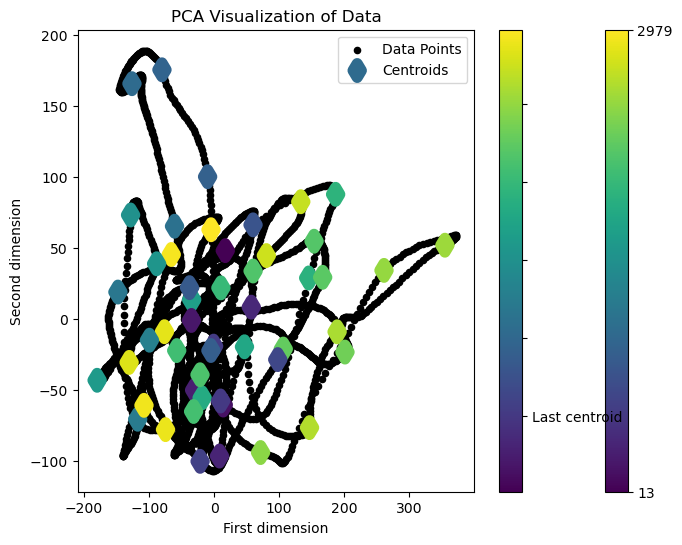

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

v = 1
Z = pos_cent[v][0].values  
pca = PCA(n_components=2) # me diga a PCA cuales son las dimensiones más representativas
x = pca.fit_transform(Z)

# Plot
plt.figure(figsize=(8, 6))  # Ajusta el tamaño de la figura según sea necesario
plt.scatter(x[:, 0], x[:, 1], color='k', s=20, label='Data Points')  # Ajusta el tamaño de los marcadores según sea necesario
plt.scatter(x[ind[v], 0], x[ind[v], 1], marker='d', s=50, linewidths=8, c=ind[v], label='Centroids')
plt.colorbar().set_ticks([np.min(ind[v]), np.max(ind[v])])
plt.colorbar().set_ticklabels(['First centroid', 'Last centroid'])
plt.xlabel('First dimension')
plt.ylabel('Second dimension')
plt.title('PCA Visualization of Data')
# Descomenta el siguiente bloque si deseas agregar etiquetas de los puntos
# for j in range(ind.shape[1]):
#     plt.text(x[ind[v,j], 0], x[ind[v,j], 1], ind[v,j], fontsize=12, color='r')

# Guardar la figura
plt.savefig('throw_pca.pdf', bbox_inches='tight')

# Mostrar la figura
plt.legend()
plt.show()


# Parámetros Kernels

## definir lista de movimientos

In [14]:
# We define the name of the labels according to the type of activity
list_mov = ['derecha', 'remate', 'reves', 'servicio', 'vderecha', 'vreves']

In [76]:
#Labels is built
X = []
nlabs = []
filename = 'Data_clus_CMU_demo'
for j in range(len(list_folder)):
    list_trials = os.listdir(direcctorio_principal + list_folder[j])
    list_trials = sorted(list_trials)
    for i in range(min(len(list_trials), len(Xa))):  # Usar el menor entre el tamaño de list_trials y Xa
        print(list_trials[i])
        X += [Xa[i]]
    nlabs += [len(list_trials)]
# Asumiendo que list_mov tiene que coincidir con nlabs en tamaño
if len(list_mov) == len(nlabs):
    labels_name = np.repeat(list_mov, nlabs, axis=0)
else:
    # Ajustar para que list_mov y nlabs coincidan
    min_len = min(len(list_mov), len(nlabs))
    labels_name = np.repeat(list_mov[:min_len], nlabs[:min_len], axis=0)

labels = np.repeat(list_folder, nlabs, axis=0)
labels = labels.reshape(-1, 1)
labels_name = labels_name.reshape(-1, 1)

X += [labels]
joblib.dump(X, filename + ".pkl")

adorozco_Derecha.bvh
adorozco_Remate.bvh
adorozco_Reves.bvh
adorozco_Servicio.bvh
astrejos_Derecha.bvh
astrejos_Remate.bvh
astrejos_Reves.bvh
astrejos_Servicio.bvh


['Data_clus_CMU_demo.pkl']

In [16]:
print(Xa[1][1])

for i in range(len(list_trials)):
    if i < len(Xa):
        X += [Xa[i]]
    else:
        print(f"Advertencia: i ({i}) es mayor que el tamaño de Xa ({len(Xa)})")

[  0.         141.551739    70.646522    -6.49838962 141.57894305
  80.0129629   11.88244206 110.5410481   92.38363417  -2.43516136
  73.81891139  94.11314762  12.02063678  67.93230378 100.41892653
   6.49838962 141.52453495  61.2800811   12.22650315 104.27803163
  55.43832543   5.45591349  69.39677191  38.29314696  18.891738
  62.20857587  45.44811407   4.25729303 170.49168238  73.51615685
   8.72522977 190.79937383  79.12642627  -5.51271457 182.25123173
  89.34700394  -7.04738437 162.15202814  93.7480506   12.40098702
 148.18222948  99.73645616  25.03405019 149.0038657  106.2781019
   8.72522977 190.79937383  79.12642627  16.63984702 188.3686737
  61.47138363  24.64915776 169.36171768  60.9338219   33.90700975
 165.50202561  83.48710058  35.552412   166.94456614  97.56808877
   8.72522977 190.79937383  79.12642627  11.70447047 200.81313454
  78.90010519  12.19307093 216.80853416  76.72500581]
Advertencia: i (2) es mayor que el tamaño de Xa (2)
Advertencia: i (3) es mayor que el tamañ

In [17]:
print(len(list_mov))

6


In [18]:
print(labels)

[['01']
 ['01']
 ['01']
 ['01']
 ['01']
 ['01']
 ['02']
 ['02']
 ['02']
 ['02']
 ['02']
 ['02']]


In [19]:
print(labels_name)

[['derecha']
 ['derecha']
 ['derecha']
 ['derecha']
 ['derecha']
 ['derecha']
 ['remate']
 ['remate']
 ['remate']
 ['remate']
 ['remate']
 ['remate']]


In [20]:
print(list_trials)

['astrejos_Derecha.bvh', 'astrejos_Remate.bvh', 'astrejos_Reves.bvh', 'astrejos_Servicio.bvh', 'astrejos_VDerecha.bvh', 'astrejos_VReves.bvh']


In [50]:
print(X)

[array([[  0.        , 153.768478  ,  46.706169  , ...,   3.67685502,
        231.74444302,  57.83450585],
       [  0.        , 162.124992  ,  96.414827  , ...,   2.72160852,
        241.87151027, 109.50129012],
       [  0.        , 132.435307  ,  -3.469181  , ...,   8.47910061,
        213.72818823,   3.7991956 ],
       ...,
       [  0.        , 160.434807  , 105.875821  , ...,  -5.83634271,
        240.0557126 , 117.65475528],
       [  0.        , 149.161805  ,  57.475966  , ...,   5.63070799,
        230.88064518,  56.10622896],
       [  0.        , 164.582542  ,  96.93322   , ...,  -0.71739162,
        245.6576625 , 100.99967891]]), array([[  0.        , 184.381118  ,  84.658213  , ..., -38.0925301 ,
        240.41519315, 114.18093189],
       [  0.        , 141.551739  ,  70.646522  , ...,  12.19307093,
        216.80853416,  76.72500581],
       [  0.        , 166.765716  ,  85.544538  , ...,  13.80802908,
        240.98897068,  91.43305426],
       ...,
       [  0.       

In [22]:
# Sigma parameters is computed
Sigx = np.zeros((Xa.shape[0]))
#Sigy = np.zeros((Y.shape[0]))
for i in range(Xa.shape[0]):
  Dx = pairwise_distances(Xa[i],Xa[i])
  Sigx[i] = np.median(Dx)
  #Dy = pairwise_distances(Y[i],Y[i])
  #Sigy[i] = np.median(Dy)
Sigma_x = np.median(Sigx)
Sigma_y = Sigma_x

## dissimilarity matrix 

In [23]:
Sigx

array([227.47661823, 185.55838931])

In [24]:
Sigma_x

206.5175037710575

In [25]:
Sigma_y

206.5175037710575

In [26]:
Dx

array([[2.15791864e-05, 2.68124257e+02, 2.43309885e+02, ...,
        2.62376481e+02, 2.14041620e+02, 4.02706654e+02],
       [2.68124257e+02, 0.00000000e+00, 1.80677826e+02, ...,
        1.58012374e+02, 1.05003255e+02, 2.31000990e+02],
       [2.43309885e+02, 1.80677826e+02, 1.52587891e-05, ...,
        2.33998306e+02, 1.77431391e+02, 3.54343847e+02],
       ...,
       [2.62376481e+02, 1.58012374e+02, 2.33998306e+02, ...,
        1.52587891e-05, 1.47752070e+02, 2.07115534e+02],
       [2.14041620e+02, 1.05003255e+02, 1.77431391e+02, ...,
        1.47752070e+02, 0.00000000e+00, 2.48488352e+02],
       [4.02706654e+02, 2.31000990e+02, 3.54343847e+02, ...,
        2.07115534e+02, 2.48488352e+02, 1.07895932e-05]])

In [27]:
print(len(Dx))

50


adorozco_Derecha.bvh
adorozco_Remate.bvh
astrejos_Derecha.bvh
astrejos_Remate.bvh
Sigma_x: 206.5175037710575
Sigma_y: 206.5175037710575


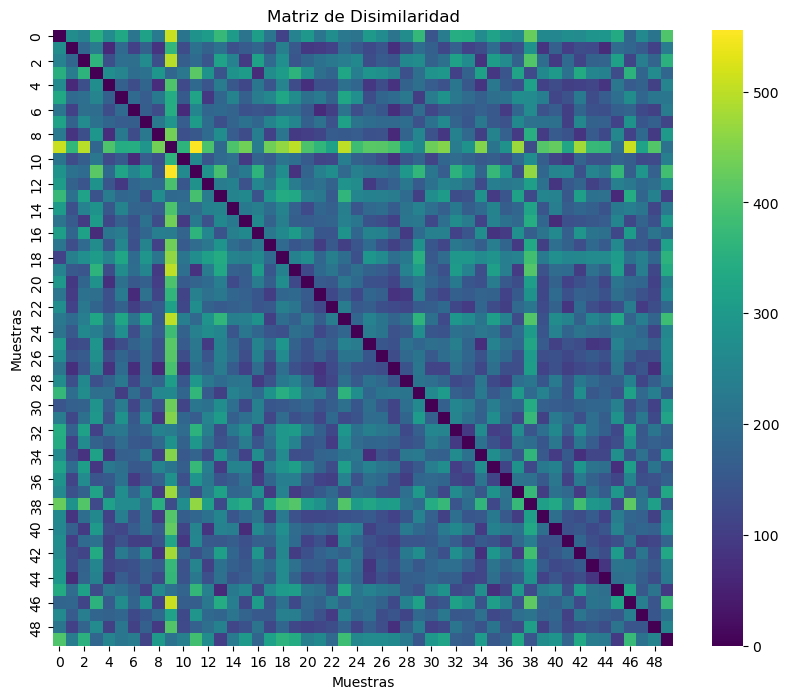

In [54]:
import os
import numpy as np
import joblib
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import seaborn as sns

# Definir las etiquetas según el tipo de actividad
list_mov = ['derecha', 'remate', 'reves', 'servicio', 'vderecha', 'vreves']
X = []
nlabs = []
filename = 'Data_clus_CMU_demo'

# Suponiendo que 'list_folder' y 'direcctorio_principal' ya están definidos
for j in range(len(list_folder)):
    list_trials = os.listdir(direcctorio_principal + list_folder[j])
    list_trials = sorted(list_trials)
    for i in range(min(len(list_trials), len(Xa))):  # Usar el menor entre el tamaño de list_trials y Xa
        print(list_trials[i])
        X.append(Xa[i])  # Agregar el elemento de Xa a la lista X
    nlabs.append(len(list_trials))  # Guardar el número de pruebas de cada carpeta

# Verificar si 'list_mov' y 'nlabs' tienen el mismo tamaño
if len(list_mov) == len(nlabs):
    labels_name = np.repeat(list_mov, nlabs, axis=0)
else:
    # Ajustar para que 'list_mov' y 'nlabs' coincidan en tamaño
    min_len = min(len(list_mov), len(nlabs))
    labels_name = np.repeat(list_mov[:min_len], nlabs[:min_len], axis=0)

# Crear las etiquetas según las carpetas
labels = np.repeat(list_folder, nlabs, axis=0)
labels = labels.reshape(-1, 1)
labels_name = labels_name.reshape(-1, 1)

# Agregar las etiquetas a la lista X
X.append(labels)

# Guardar los datos en un archivo .pkl
joblib.dump(X, filename + ".pkl")

# Cálculo de la matriz de disimilaridad y sigma
Sigx = np.zeros((len(Xa)))
for i in range(len(Xa)):
    Dx = pairwise_distances(Xa[i], Xa[i])
    Sigx[i] = np.median(Dx)

Sigma_x = np.median(Sigx)
Sigma_y = Sigma_x

print("Sigma_x:", Sigma_x)
print("Sigma_y:", Sigma_y)

# Graficar la matriz de disimilaridad
plt.figure(figsize=(10, 8))
sns.heatmap(Dx, cmap='viridis', annot=False)
plt.title("Matriz de Disimilaridad")
plt.xlabel("Muestras")
plt.ylabel("Muestras")
plt.show()


## Ajustar Metodo FIT

In [55]:
print(dist)

SHECCO(Ax=50, Ay=50, sigmax=206.5175037710575, sigmay=206.5175037710575)


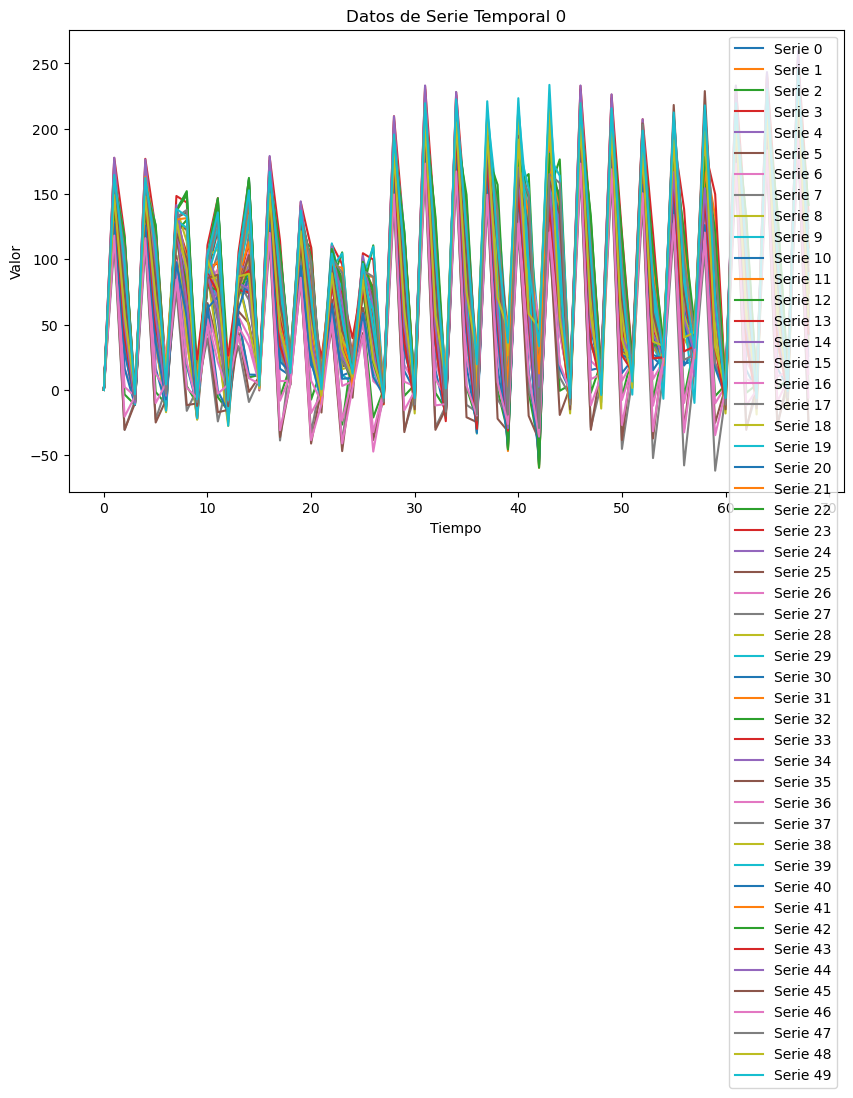

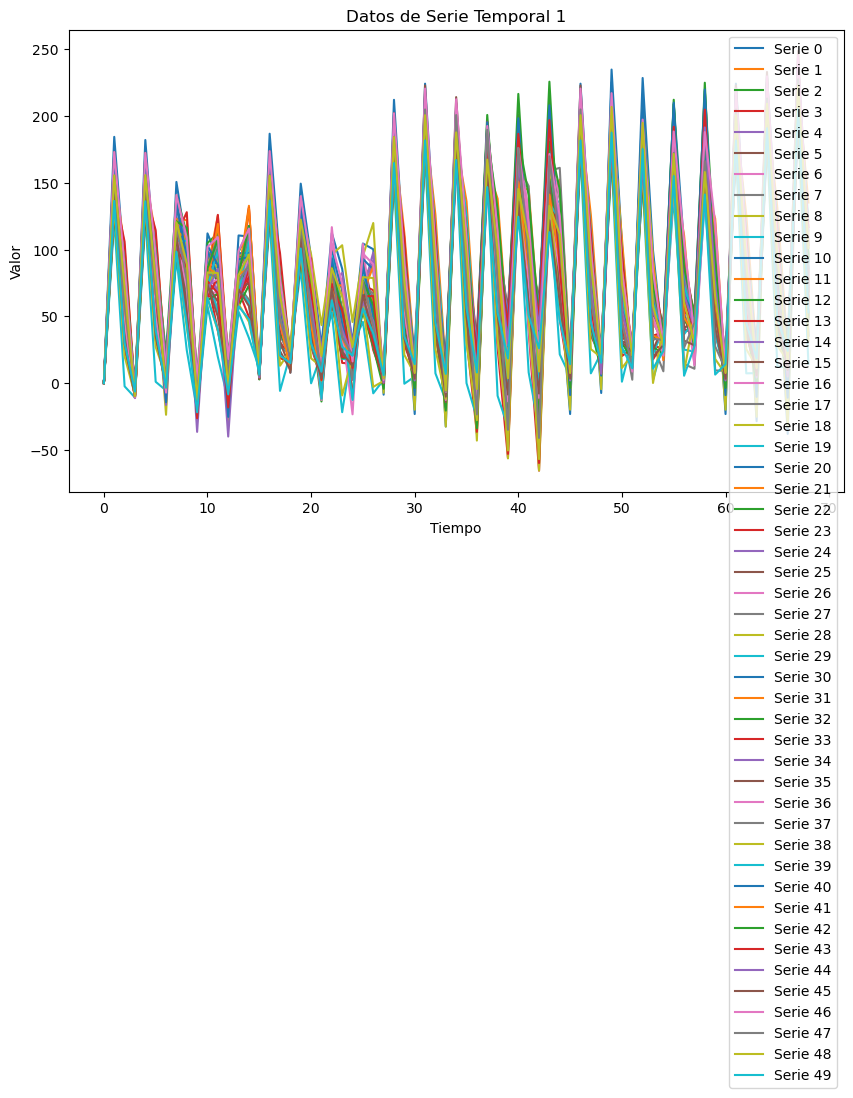

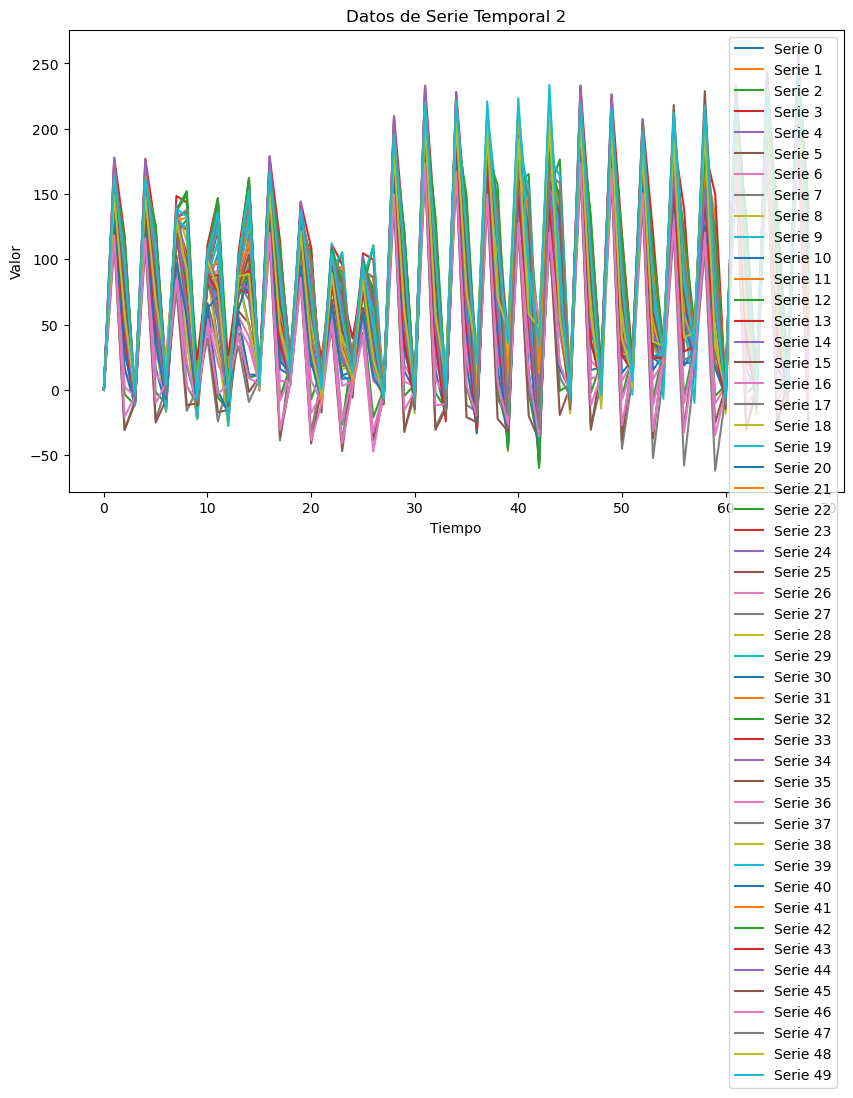

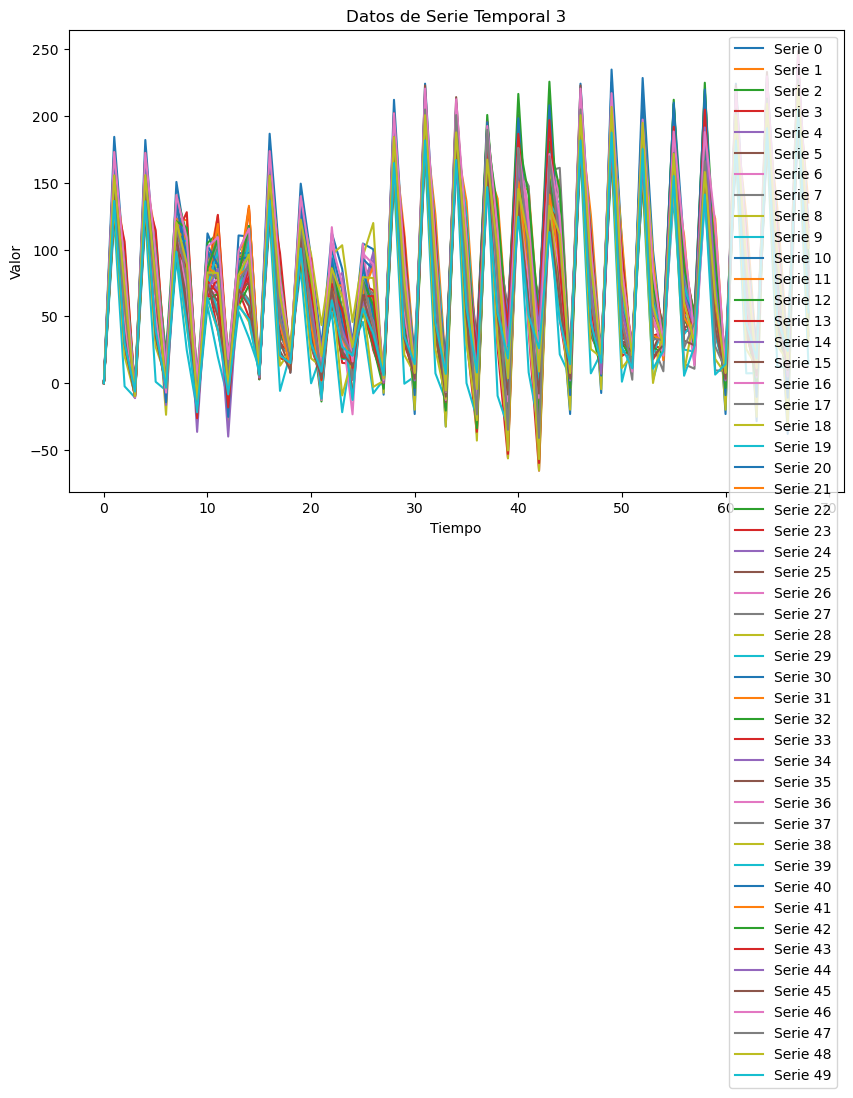

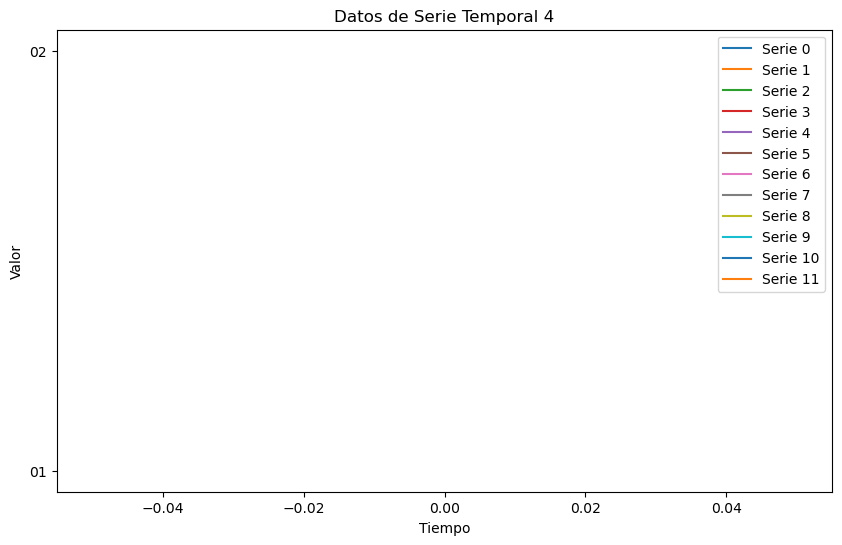

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Supongamos que X es una lista de matrices donde cada matriz es una serie temporal
for idx, matrix in enumerate(X):
    plt.figure(figsize=(10, 6))
    for i in range(matrix.shape[0]):  # Asumamos que la primera dimensión es la cantidad de series
        plt.plot(matrix[i, :], label=f'Serie {i}')
    plt.title(f'Datos de Serie Temporal {idx}')
    plt.xlabel('Tiempo')
    plt.ylabel('Valor')
    plt.legend()
    plt.show()


## 9. Visualizamos el espacio generado por la matriz de disimilitud utilizando TSNE

Ajustando labels de tamaño 12 a 50


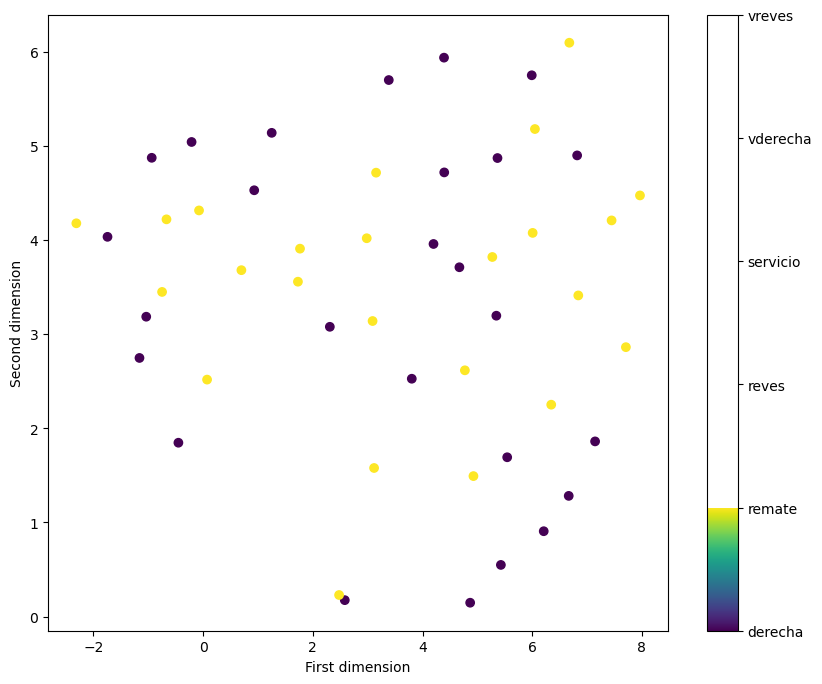

In [56]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Configuración de t-SNE
red = TSNE(metric='precomputed', perplexity=20.0, init='random')

# Verifica que la matriz Dx sea cuadrada
if Dx.shape[0] != Dx.shape[1]:
    raise ValueError("La matriz de distancias Dx debe ser cuadrada.")

# Calcula la transformación t-SNE
ztrain = red.fit_transform(Dx)

# Asegúrate de que labels tenga el mismo tamaño que ztrain
if len(labels) != len(ztrain):
    print(f"Ajustando labels de tamaño {len(labels)} a {len(ztrain)}")
    labels = np.resize(labels, len(ztrain))

# Convierte labels a números enteros si están como cadenas de texto
try:
    labels = labels.astype(int)
except ValueError:
    # Si las etiquetas no son convertibles directamente a int
    unique_labels = np.unique(labels)
    label_mapping = {label: idx for idx, label in enumerate(unique_labels)}
    labels = np.array([label_mapping[label] for label in labels])

# Visualizar espacio generado por las distancias con t-SNE
plt.figure(figsize=(10, 8))
scatter = plt.scatter(ztrain[:, 0], ztrain[:, 1], c=labels, cmap='viridis')
plt.xlabel('First dimension')
plt.ylabel('Second dimension')

# Configurar la barra de color
a = plt.colorbar(scatter)
a.set_ticks(np.arange(1, len(list_mov) + 1))
a.set_ticklabels(list_mov)

# Guarda la figura
plt.savefig('TSNE_CMU.pdf', bbox_inches='tight')

plt.show()



## 10. Ajustamos los parámetros asociados al clasificador en función de un SVM

In [62]:

  steps=[('pre',  StandardScaler()),
         ('svc', SVC(kernel='rbf'))] 
  parameters = {                   
                'svc__C': [1 ,10,100,1000,10000],
                'svc__gamma': [0.01,0.1,1,100,1000]    
               }

  label_model = ['SHECCO_SVC']

In [63]:
#crear carpeta con resultados
import os
try:
  os.mkdir('datos_mocap2')
except:
  print("Carpeta results ya existe")

Carpeta results ya existe


In [65]:
print(X)

[array([[  0.        , 153.768478  ,  46.706169  , ...,   3.67685502,
        231.74444302,  57.83450585],
       [  0.        , 162.124992  ,  96.414827  , ...,   2.72160852,
        241.87151027, 109.50129012],
       [  0.        , 132.435307  ,  -3.469181  , ...,   8.47910061,
        213.72818823,   3.7991956 ],
       ...,
       [  0.        , 160.434807  , 105.875821  , ...,  -5.83634271,
        240.0557126 , 117.65475528],
       [  0.        , 149.161805  ,  57.475966  , ...,   5.63070799,
        230.88064518,  56.10622896],
       [  0.        , 164.582542  ,  96.93322   , ...,  -0.71739162,
        245.6576625 , 100.99967891]]), array([[  0.        , 184.381118  ,  84.658213  , ..., -38.0925301 ,
        240.41519315, 114.18093189],
       [  0.        , 141.551739  ,  70.646522  , ...,  12.19307093,
        216.80853416,  76.72500581],
       [  0.        , 166.765716  ,  85.544538  , ...,  13.80802908,
        240.98897068,  91.43305426],
       ...,
       [  0.       

In [66]:
print(Xa)

[[[  0.         153.768478    46.706169   ...   3.67685502 231.74444302
    57.83450585]
  [  0.         162.124992    96.414827   ...   2.72160852 241.87151027
   109.50129012]
  [  0.         132.435307    -3.469181   ...   8.47910061 213.72818823
     3.7991956 ]
  ...
  [  0.         160.434807   105.875821   ...  -5.83634271 240.0557126
   117.65475528]
  [  0.         149.161805    57.475966   ...   5.63070799 230.88064518
    56.10622896]
  [  0.         164.582542    96.93322    ...  -0.71739162 245.6576625
   100.99967891]]

 [[  0.         184.381118    84.658213   ... -38.0925301  240.41519315
   114.18093189]
  [  0.         141.551739    70.646522   ...  12.19307093 216.80853416
    76.72500581]
  [  0.         166.765716    85.544538   ...  13.80802908 240.98897068
    91.43305426]
  ...
  [  0.         155.408096    58.091672   ...  21.36353471 227.5342869
    69.27744952]
  [  0.         155.507148    71.292807   ...  16.50979929 222.83983934
   101.05348903]
  [  0.   

## 11. Ejecutamos los procesos de entrenamiento y validación del clasificador, además ajustamos los parámetros mediante validación cruzada.

In [74]:
import joblib

# Cargar el archivo pkl y revisar su contenido
filename = 'Data_clus_CMU_demo.pkl'
data = joblib.load(filename)

# Mostrar la estructura y contenido de los datos
if isinstance(data, (list, tuple)):
    print(f"Contenido del archivo: {len(data)} elementos")
    for i, item in enumerate(data):
        print(f"Elemento {i}: {type(item)}, forma {getattr(item, 'shape', 'N/A')}")
else:
    print(f"Contenido del archivo: {type(data)}, forma {getattr(data, 'shape', 'N/A')}")


Contenido del archivo: 5 elementos
Elemento 0: <class 'numpy.ndarray'>, forma (50, 69)
Elemento 1: <class 'numpy.ndarray'>, forma (50, 69)
Elemento 2: <class 'numpy.ndarray'>, forma (50, 69)
Elemento 3: <class 'numpy.ndarray'>, forma (50, 69)
Elemento 4: <class 'numpy.ndarray'>, forma (12, 1)


In [85]:
# Verificar el tamaño de cada matriz en data
for i, mat in enumerate(data):
    print(f"Elemento {i}: {mat.shape}")


Elemento 0: (50, 69)
Elemento 1: (50, 69)
Elemento 2: (50, 69)
Elemento 3: (50, 69)
Elemento 4: (50, 69)
Elemento 5: (50, 69)
Elemento 6: (50, 69)
Elemento 7: (50, 69)
Elemento 8: (12, 1)


In [87]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score

# Cargar los datos
filename = 'Data_clus_CMU_demo.pkl'
data = joblib.load(filename)

# Combinación de matrices de datos
Xa_combined = np.vstack(data[:-1])  # Combinar las primeras 8 matrices
labels = data[-1].ravel()  # El último elemento son las etiquetas

# Verificar consistencia entre el número de muestras y etiquetas
num_samples = Xa_combined.shape[0]
num_labels = len(labels)

print("Número de muestras en Xa_combined:", num_samples)
print("Número de etiquetas en labels:", num_labels)

# Verificar si los números coinciden
if num_samples != num_labels:
    raise ValueError("El número de muestras en Xa_combined no coincide con el número de etiquetas en labels.")

# Definir el pipeline y los parámetros para SVC
steps = [('pre', StandardScaler()), ('svc', SVC(kernel='rbf'))]
parameters = {                   
    'svc__C': [1, 10, 100, 1000, 10000],
    'svc__gamma': [0.01, 0.1, 1, 100, 1000]    
}

# Crear el pipeline
pipeline = Pipeline(steps=steps)

# Crear el objeto GridSearchCV
grid_search = GridSearchCV(pipeline, parameters, cv=5, verbose=1, scoring='accuracy', n_jobs=-1)

# Configurar la validación cruzada
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

# Almacenar los resultados
results = []

# Validación cruzada
for train_index, test_index in sss.split(Xa_combined, labels):
    X_train, X_test = Xa_combined[train_index], Xa_combined[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    
    y_pred = grid_search.best_estimator_.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    cm = 100 * cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    results.append({
        'best_params': best_params,
        'best_score': best_score,
        'accuracy': acc,
        'confusion_matrix': cm
    })

# Graficar los resultados de GridSearchCV
cv_results = grid_search.cv_results_

# Parámetros y puntuaciones
param_C = cv_results['param_svc__C']
param_gamma = cv_results['param_svc__gamma']
mean_test_score = cv_results['mean_test_score']

# Crear un DataFrame para la visualización
import pandas as pd
results_df = pd.DataFrame({
    'C': param_C,
    'gamma': param_gamma,
    'mean_test_score': mean_test_score
})

# Graficar los resultados
plt.figure(figsize=(12, 6))
sns.heatmap(results_df.pivot_table(index='C', columns='gamma', values='mean_test_score'), cmap='viridis', annot=True)
plt.title('Rendimiento del Modelo según los Hiperparámetros')
plt.xlabel('gamma')
plt.ylabel('C')
plt.show()

# Graficar la matriz de confusión
for result in results:
    plt.figure(figsize=(8, 6))
    sns.heatmap(result['confusion_matrix'], annot=True, cmap='Blues', fmt='g')
    plt.title('Matriz de Confusión')
    plt.xlabel('Etiqueta Predicha')
    plt.ylabel('Etiqueta Real')
    plt.show()

# Imprimir los mejores parámetros y el mejor score
print(f"Mejores parámetros: {grid_search.best_params_}")
print(f"Mejor score: {grid_search.best_score_:.2f}")


Número de muestras en Xa_combined: 400
Número de etiquetas en labels: 12


ValueError: El número de muestras en Xa_combined no coincide con el número de etiquetas en labels.